In [1]:
# import configurations saved from the EDA project
from configurations import *

In [2]:
# import the necessary libraries
from sklearn import preprocessing
import math
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, auc, make_scorer, classification_report, recall_score, precision_score, confusion_matrix, average_precision_score, precision_recall_curve 
from sklearn.model_selection import cross_val_score, learning_curve, GridSearchCV, StratifiedKFold

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

import shap


#### Feature Pre-Processing

- nominal features
    - menopause
    - node_caps
    - breast
    - breast_quad
    - irrad
    - class (*target feature*)
- ordinal features
    - age
    - tumour_size
    - inv_nodes
- numerical feature
    - deg_malig

In [3]:
columns_to_keep = ['node_caps', 'inv_nodes', 'irrad', 'deg_malig']
X_train = X_train[columns_to_keep]

In [4]:
# Encode nominal features using one-hot encoding with drop_first=True
X_train_nominal = pd.get_dummies(X_train[['node_caps', 'irrad']], drop_first=True)

In [5]:
# Perform label encoding for ordinal features
label_encoder = preprocessing.LabelEncoder()
X_train_ordinal = X_train[['inv_nodes']].copy()  
for col in X_train_ordinal.columns:
    X_train_ordinal.loc[:, col] = label_encoder.fit_transform(X_train_ordinal[col])

In [6]:
X_train_numerical = X_train[['deg_malig']]

In [7]:
X_train_encoded = pd.concat([X_train_nominal, X_train_ordinal, X_train_numerical], axis=1)

In [8]:
X_train_encoded.head()

,node_caps_yes,irrad_yes,inv_nodes,deg_malig
215,False,False,0,2
41,False,False,0,2
24,False,False,0,2
161,True,False,4,2
144,True,False,5,3


In [9]:
y_train_encoded = y_train.replace(['no-recurrence-events', 'recurrence-events'], [0,1])

In [10]:
# create a validation set to train and evaluate the model
X_train_eval, X_eval, y_train_eval, y_eval = train_test_split(X_train_encoded, y_train_encoded, test_size=0.2, stratify=y_train_encoded, random_state=42)

#### Dirty Training of Models for Benchmark

In [11]:
models = [
    RandomForestClassifier(),
    LogisticRegression(),
    DecisionTreeClassifier(),
    KNeighborsClassifier(),
    SVC(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()
]

for model in models:
    model.fit(X_train_eval, y_train_eval)
    y_pred = model.predict(X_eval)
    report = classification_report(y_eval, y_pred)
    print(model)
    print(report)

RandomForestClassifier()
              precision    recall  f1-score   support

           0       0.76      0.91      0.83        32
           1       0.62      0.36      0.45        14

    accuracy                           0.74        46
   macro avg       0.69      0.63      0.64        46
weighted avg       0.72      0.74      0.71        46

LogisticRegression()
              precision    recall  f1-score   support

           0       0.77      0.94      0.85        32
           1       0.71      0.36      0.48        14

    accuracy                           0.76        46
   macro avg       0.74      0.65      0.66        46
weighted avg       0.75      0.76      0.73        46

DecisionTreeClassifier()
              precision    recall  f1-score   support

           0       0.72      0.97      0.83        32
           1       0.67      0.14      0.24        14

    accuracy                           0.72        46
   macro avg       0.69      0.56      0.53        46
wei

#### Training of Models with Resampling

In [12]:
ros = RandomOverSampler(random_state=42,
                        sampling_strategy='minority'
                        )
#ros = SMOTE(random_state=42)
#X_train_resampled, y_train_resampled = ros.fit_resample(X_train_eval, y_train_eval)
X_train_resampled, y_train_resampled = X_train_eval, y_train_eval

In [13]:
rfc_parameters = {
    'n_estimators': [50, 200, 300, 500],
    'max_depth': [3, 8, 15],
    'min_samples_split': [2, 5, 10],
    'class_weight': [{0:1, 1:2}]
}

knn_parameters = {
    'n_neighbors': [5, 7],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'kd_tree', 'brute'],
    'leaf_size': [10, 30, 50]
}

lr_parameters = {
    'penalty': ['l2', None], 
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'class_weight': [{0:1, 1:1.6}]
}

dtc_parameters = {
    'max_depth': [None, 3, 5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

svc_parameters = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}

lda_parameters = {
    'solver': ['svd', 'lsqr', 'eigen']
}

qda_parameters = {
    'store_covariance': [False, True]
}

In [14]:
def best_param(model, X_train, y_train, parameters):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scorer = make_scorer(f1_score)
    grid_search = GridSearchCV(estimator=model, param_grid=parameters, cv=cv, scoring=scorer, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    model.set_params(**best_params)
    return model


def pred(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    return model, report


In [15]:
dfs = []

model_param_list = [
    (RandomForestClassifier(), rfc_parameters),
    (KNeighborsClassifier(), knn_parameters),
    (LogisticRegression(), lr_parameters),
    (DecisionTreeClassifier(), dtc_parameters),
    (SVC(), svc_parameters),
    (LinearDiscriminantAnalysis(), lda_parameters),
    (QuadraticDiscriminantAnalysis(), qda_parameters)
    ]


for model, model_parameters in zip(models, [rfc_parameters, lr_parameters, dtc_parameters, knn_parameters, svc_parameters, lda_parameters, qda_parameters]): 
    model_best = best_param(model, X_train_resampled, y_train_resampled, model_parameters)
    if 'Random' in str(model_best):
        random_model_best = model_best
    elif 'Logistic' in str(model_best):
        logistic_model_best = model_best
    elif 'Decision' in str(model_best):
        decision_model_best = model_best
    elif 'KN' in str(model_best):
        kn_model_best = model_best
    elif 'Linear' in str(model_best):
        lda_model_best = model_best
    elif 'Quadratic' in str(model_best):
        qda_model_best = model_best
    else:
        svc_model_best = model_best
    _, report1 = pred(model_best, X_train_resampled, y_train_resampled, X_eval, y_eval)



    df = pd.DataFrame({
        'processing': ['Combination Sampling'],
        'weighted avg_precision': [report1['weighted avg']['precision']],
        'weighted avg_recall': [report1['weighted avg']['recall']],
        'weighted avg_f1-score': [report1['weighted avg']['f1-score']],
        'precision_0': [report1['0']['precision']],
        'precision_1': [report1['1']['precision']],
        'recall_0': [report1['0']['recall']],
        'recall_1': [report1['1']['recall']],
        'f1-score_0': [report1['0']['f1-score']],
        'f1-score_1': [report1['1']['f1-score']],
        'support_0': [report1['0']['support']],
        'support_1': [report1['1']['support']]
    })

    df = df.set_index('processing')
    dfs.append(df)





# Concatenate all DataFrames
result = pd.concat(dfs, keys=[str(i) for i in range(len(dfs))])
result = result.round(2)

new_labels = {
    '0': 'RandomForestClassifier()',
    '1': 'LogisticRegression()',
    '2': 'DecisionTreeClassifier()',
    '3': 'KNeighborsClassifier()',
    '4': 'SVC()',
    '5': 'LinearDiscriminantAnalysis()',
    '6': 'QuadraticDiscriminantAnalysis()'}

# Rename the index labels using the dictionary
result = result.rename(index=new_labels)



format_dict = {
    'weighted avg_precision': '{:.2f}',
    'weighted avg_recall': '{:.2f}',
    'weighted avg_f1-score': '{:.2f}',
    'precision_0': '{:.2f}',
    'precision_1': '{:.2f}',
    'recall_0': '{:.2f}',
    'recall_1': '{:.2f}',
    'f1-score_0': '{:.2f}',
    'f1-score_1': '{:.2f}',
}

for col in ['support_0', 'support_1']:
    format_dict[col] = '{}'

highlighted = result.style.apply(lambda x: ['background-color: darkgreen; color: white;' if col == 'recall_1' else '' for col in x.index], axis=1).format(format_dict)


highlighted

Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters


,,weighted avg_precision,weighted avg_recall,weighted avg_f1-score,precision_0,precision_1,recall_0,recall_1,f1-score_0,f1-score_1,support_0,support_1
,processing,,,,,,,,,,,
RandomForestClassifier(),Combination Sampling,0.70,0.72,0.70,0.76,0.56,0.88,0.36,0.81,0.43,32,14
LogisticRegression(),Combination Sampling,0.70,0.72,0.71,0.77,0.55,0.84,0.43,0.81,0.48,32,14
DecisionTreeClassifier(),Combination Sampling,0.70,0.72,0.65,0.72,0.67,0.97,0.14,0.83,0.24,32,14
KNeighborsClassifier(),Combination Sampling,0.72,0.74,0.70,0.75,0.67,0.94,0.29,0.83,0.40,32,14
SVC(),Combination Sampling,0.72,0.74,0.70,0.75,0.67,0.94,0.29,0.83,0.40,32,14
LinearDiscriminantAnalysis(),Combination Sampling,0.69,0.72,0.68,0.74,0.57,0.91,0.29,0.82,0.38,32,14
QuadraticDiscriminantAnalysis(),Combination Sampling,0.72,0.70,0.70,0.82,0.50,0.72,0.64,0.77,0.56,32,14


In [16]:
logistic_model_best

LogisticRegression(C=0.001, class_weight={0: 1, 1: 1.6}, penalty=None)

In [17]:
final_model = logistic_model_best

In [18]:
final_model.fit(X_train_resampled, y_train_resampled)
y_pred = final_model.predict(X_eval)
report = classification_report(y_eval, y_pred)
y_score = final_model.predict_proba(X_eval)[:, 1]
print(report)

              precision    recall  f1-score   support

           0       0.77      0.84      0.81        32
           1       0.55      0.43      0.48        14

    accuracy                           0.72        46
   macro avg       0.66      0.64      0.64        46
weighted avg       0.70      0.72      0.71        46



Setting penalty=None will ignore the C and l1_ratio parameters


In [19]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)
cv_scores = cross_val_score(final_model, X_train_resampled, y_train_resampled, scoring='f1_micro', cv=cv, n_jobs=-1)
mean_cv_score = np.mean(cv_scores)
std_cv_score = np.std(cv_scores)

print("Mean cross-validation score:", round(mean_cv_score,4))
print("Standard deviation of cross-validation score:", round(std_cv_score,4))

Mean cross-validation score: 0.7444
Standard deviation of cross-validation score: 0.0313


In [20]:
# confusion matrix
cm = confusion_matrix(y_eval, y_pred)
print(cm)

[[27  5]
 [ 8  6]]


TN = 27: The model correctly predicted instances as the negative class (0).<br>
FP = 5: The model incorrectly predicted instances as the positive class (1).<br>
FN = 8: The model incorrectly predicted instances as the negative class (0).<br>
TP = 6: The model correctly predicted instances as the positive class (1).<br>

In [21]:
errors = X_eval[y_eval != y_pred]
error_labels = y_eval[y_eval != y_pred]
error_predictions = y_pred[y_eval != y_pred]

errors_with_labels = errors.assign(true_label=error_labels, predicted_label=error_predictions)

In [22]:
type_2_err = errors_with_labels[(errors_with_labels['true_label'] == 1)
                                & (errors_with_labels['predicted_label'] == 0)]

print('--- False Negatives ---')
print(display(type_2_err))

--- False Negatives ---


,node_caps_yes,irrad_yes,inv_nodes,deg_malig,true_label,predicted_label
203,False,False,0,2,1,0
237,False,False,0,2,1,0
272,True,False,0,3,1,0
260,False,False,4,2,1,0
207,False,False,0,2,1,0
254,True,False,0,3,1,0
209,False,False,0,1,1,0
262,False,False,0,3,1,0


None


In [23]:
type_1_err = errors_with_labels[(errors_with_labels['true_label'] == 0)
                                & (errors_with_labels['predicted_label'] == 1)]

print('--- False Positives ---')
print(display(type_1_err))

--- False Positives ---


,node_caps_yes,irrad_yes,inv_nodes,deg_malig,true_label,predicted_label
174,True,True,4,2,0,1
126,True,False,5,2,0,1
150,True,False,2,3,0,1
190,False,True,1,3,0,1
155,False,True,4,2,0,1


None


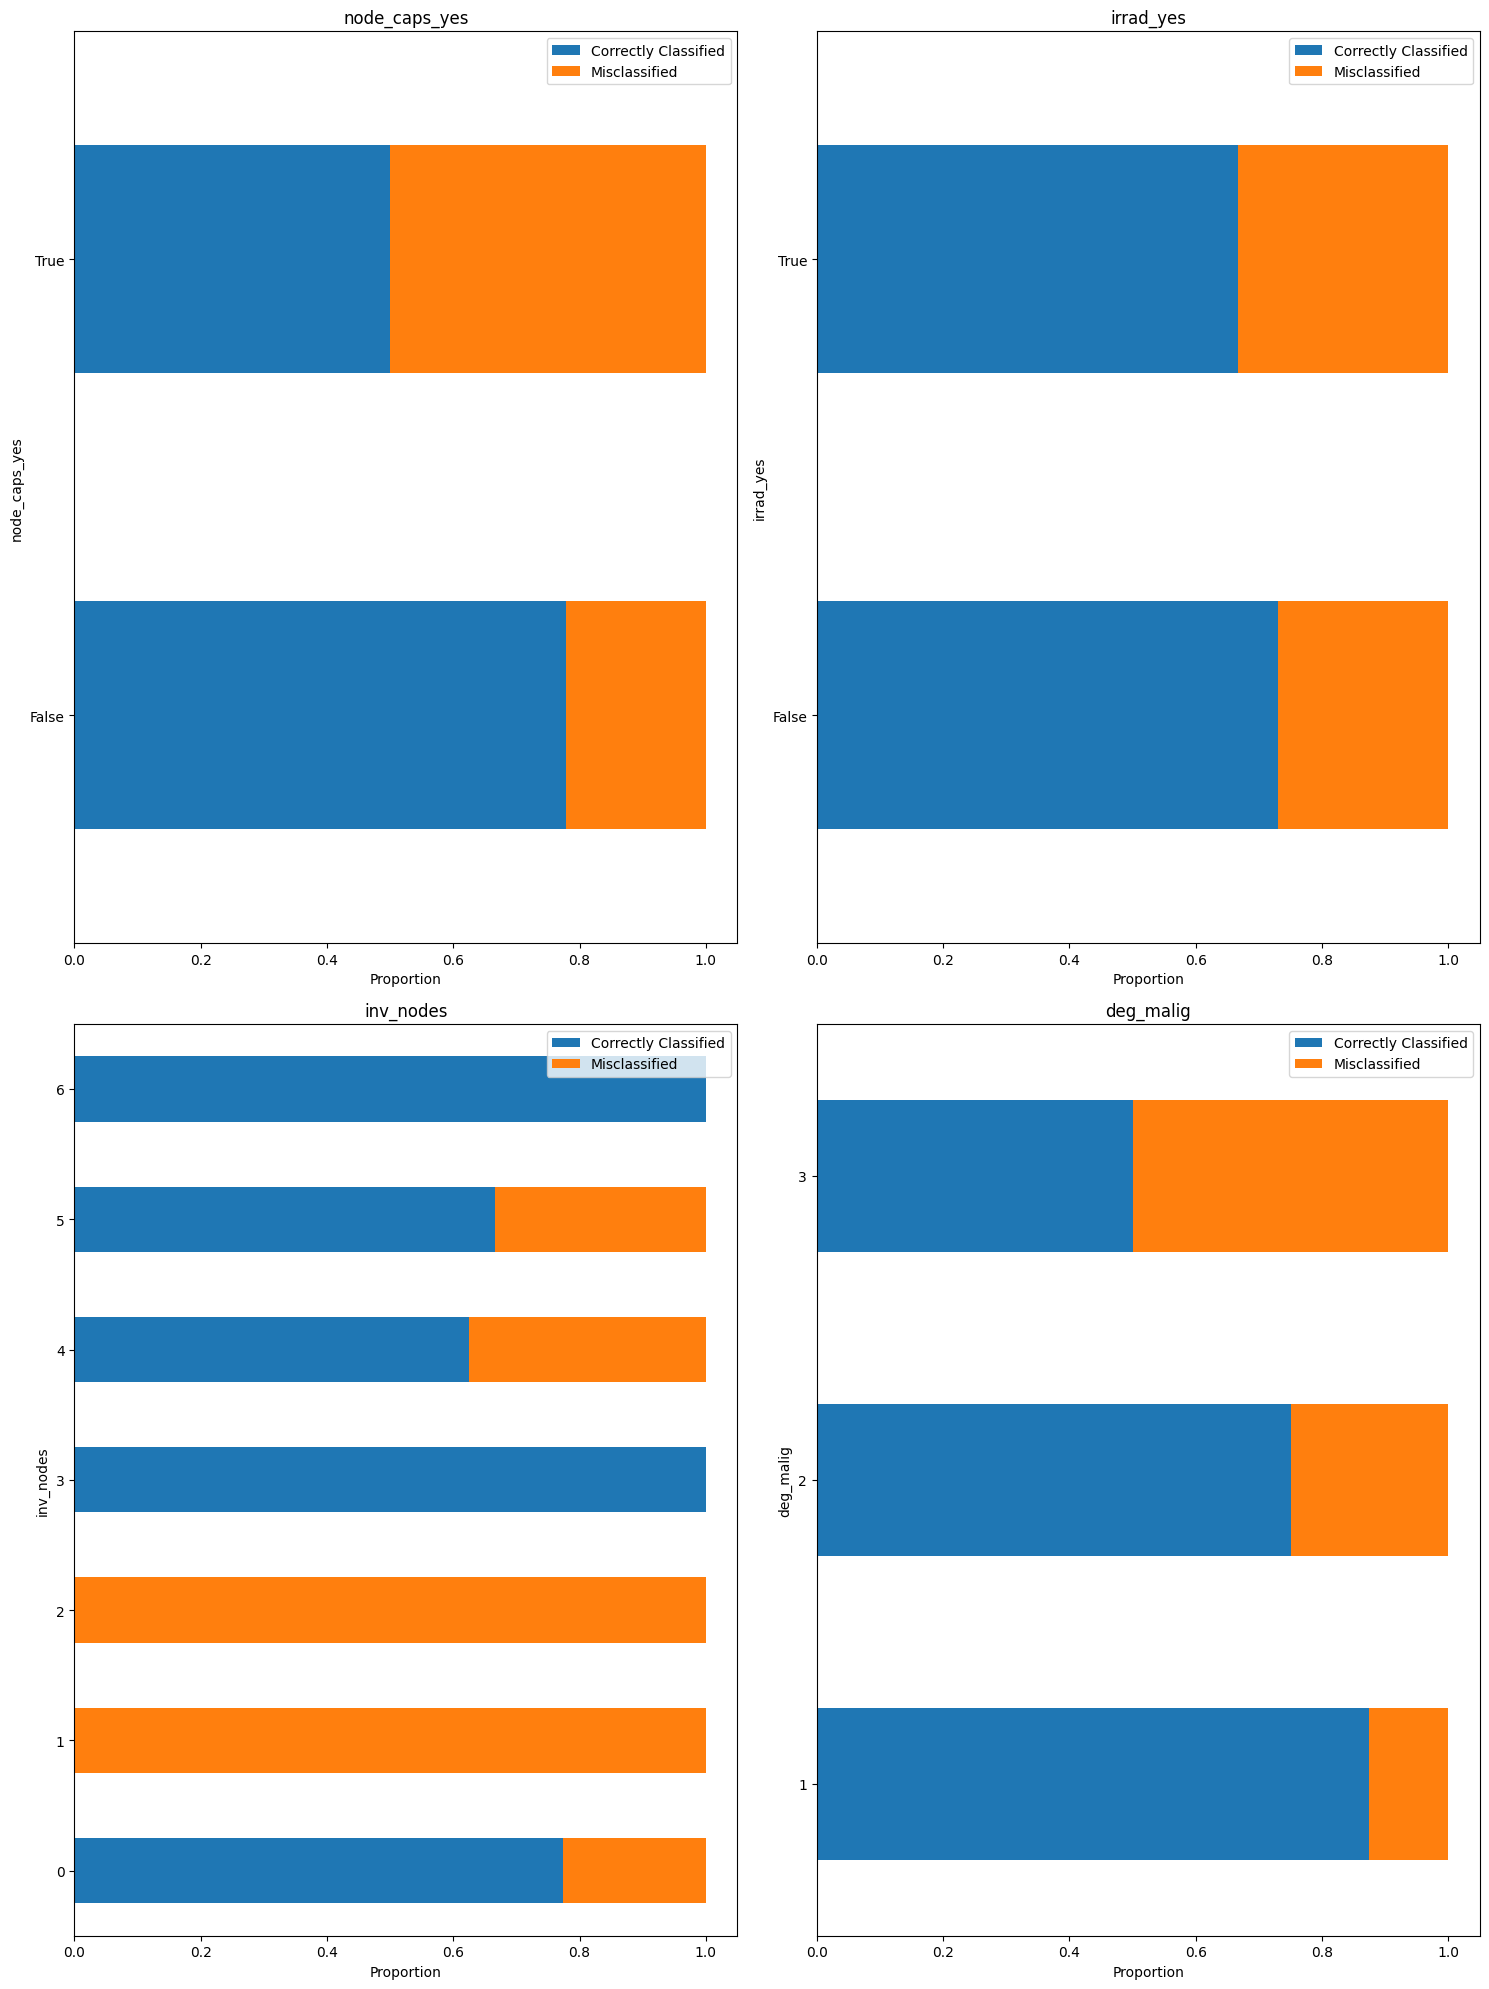

In [24]:
features = X_train_encoded.columns

# Calculate the number of rows and columns for the subplots
n_features = len(features)
ncols = 2
nrows = math.ceil(n_features / ncols)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 20))

for index, feature in enumerate(features):
    row, col = divmod(index, ncols)
    
    # Calculate the misclassification rate for each feature value
    misclassification_counts = errors_with_labels[feature].value_counts()
    overall_counts = X_eval[feature].value_counts()
    misclassification_rate = misclassification_counts / overall_counts

    # Calculate the classification rate for each feature value
    classification_counts = X_eval[y_eval == y_pred][feature].value_counts()
    classification_rate = classification_counts / overall_counts

    # Create a stacked bar chart
    rate_df = pd.DataFrame({'Correctly Classified': classification_rate, 'Misclassified': misclassification_rate}).fillna(0)
    rate_df.plot(kind='barh', stacked=True, ax=axes[row, col])
    axes[row, col].set_xlabel('Proportion')
    axes[row, col].set_ylabel(feature)
    axes[row, col].set_title(f'{feature}')
    axes[row, col].legend()


# Remove any unused subplots
for i in range(index+1, nrows*ncols):
    row, col = divmod(i, ncols)
    fig.delaxes(axes[row, col])

fig.tight_layout()
plt.show()


Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio par

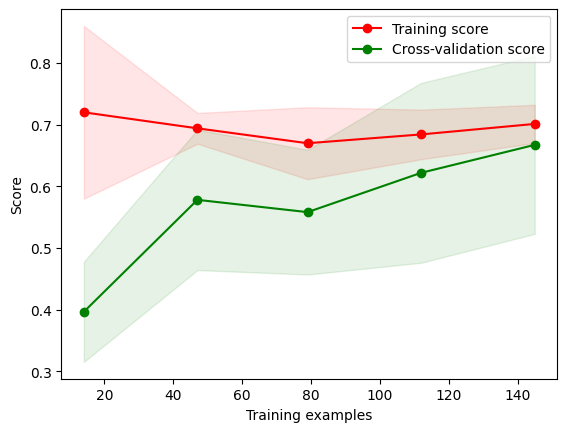

In [25]:
# Learning Curve
train_sizes, train_scores, valid_scores = learning_curve(final_model, X_train_resampled, y_train_resampled, cv=5, scoring='f1_macro')

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std,
                 valid_scores_mean + valid_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, valid_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()

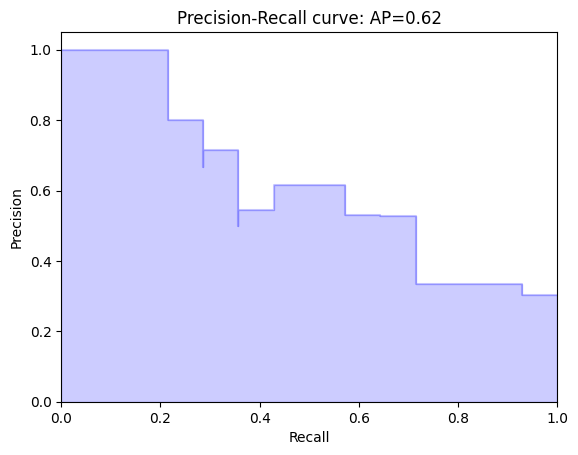

In [26]:
precision, recall, _ = precision_recall_curve(y_eval, y_score)
average_precision = average_precision_score(y_eval, y_score)

# plot the precision-recall curve
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
plt.show()

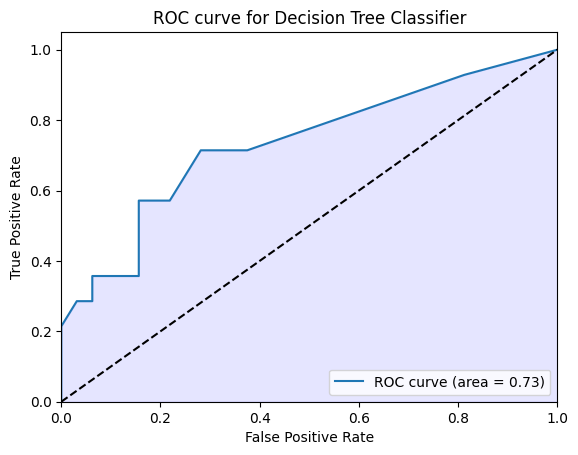

In [27]:
fpr, tpr, _ = roc_curve(y_eval, y_score)
roc_auc = auc(fpr, tpr)

# plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.fill_between(fpr, tpr, 0, color='blue', alpha=0.1)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for Decision Tree Classifier')
plt.legend(loc="lower right")
plt.show()


In [28]:
#explainer = shap.Explainer(final_model.predict, X_train_resampled)
#shap_values = explainer(X_eval)


#shap.plots.waterfall(shap_values[0])


In [29]:
#shap.plots.beeswarm(shap_values)

In [30]:
X_train_final, y_train_final = ros.fit_resample(X_train_encoded, y_train_encoded)
final_model.fit(X_train_final, y_train_final)

Setting penalty=None will ignore the C and l1_ratio parameters


LogisticRegression(C=0.001, class_weight={0: 1, 1: 1.6}, penalty=None)

In [31]:
def encoding(X_dataset, y_dataset):
    X_dataset = X_dataset[columns_to_keep]
    #X_test_nominal = pd.get_dummies(X_dataset[['node_caps', 'breast_quad', 'irrad']], drop_first=True)
    X_test_nominal = pd.get_dummies(X_dataset[['node_caps', 'irrad']], drop_first=True)
    label_encoder = preprocessing.LabelEncoder()
    #X_test_ordinal = X_dataset[['inv_nodes', 'tumour_size']].copy()
    X_test_ordinal = X_dataset[['inv_nodes']].copy()
    for col in X_test_ordinal.columns:
        X_test_ordinal[col] = label_encoder.fit_transform(X_test_ordinal[col])  
    X_test_numerical = X_dataset[['deg_malig']]                                                                                                
    X_test_encoded = pd.concat([X_test_nominal, X_test_ordinal, X_test_numerical], axis=1) 
    y_test_encoded = y_dataset.replace(['no-recurrence-events', 'recurrence-events'], [0,1]) 
    return X_test_encoded, y_test_encoded           

In [32]:
X_test_encoded, y_test_encoded = encoding(X_test, y_test)

In [33]:
y_pred = final_model.predict(X_test_encoded)
y_test_score = final_model.predict_proba(X_test_encoded)[:, 1]


target_names = ['0: no-recurrence-events', '1: recurrence-events']
report = classification_report(y_test_encoded, y_pred, target_names=target_names)
print('Model Performance on Unseen Data')
print(report)

Model Performance on Unseen Data
                         precision    recall  f1-score   support

0: no-recurrence-events       0.81      0.63      0.71        41
   1: recurrence-events       0.42      0.65      0.51        17

               accuracy                           0.64        58
              macro avg       0.62      0.64      0.61        58
           weighted avg       0.70      0.64      0.65        58



In [34]:
# confusion matrix
cm = confusion_matrix(y_test_encoded, y_pred)
print(cm)

[[26 15]
 [ 6 11]]


In [35]:
errors = X_test_encoded[y_test_encoded != y_pred]
error_labels = y_test_encoded[y_test_encoded != y_pred]
error_predictions = y_pred[y_test_encoded != y_pred]

errors_with_labels = errors.assign(true_label=error_labels, predicted_label=error_predictions)

type_2_err_final = errors_with_labels[(errors_with_labels['true_label'] == 1)
                                & (errors_with_labels['predicted_label'] == 0)]


print('--- False Negatives Final Model ---')
print(display(type_2_err_final))


--- False Negatives Final Model ---


,node_caps_yes,irrad_yes,inv_nodes,deg_malig,true_label,predicted_label
219,False,False,0,1,1,0
281,False,False,0,2,1,0
256,False,True,0,1,1,0
202,False,False,0,1,1,0
217,False,False,0,2,1,0
211,False,False,0,2,1,0


None


In [36]:
type_1_err_final = errors_with_labels[(errors_with_labels['true_label'] == 0)
                                & (errors_with_labels['predicted_label'] == 1)]


print('--- False Positives Final Model ---')
print(display(type_1_err_final))


--- False Positives Final Model ---


,node_caps_yes,irrad_yes,inv_nodes,deg_malig,true_label,predicted_label
134,False,True,0,2,0,1
151,True,False,3,3,0,1
200,False,False,0,3,0,1
160,False,True,0,3,0,1
167,True,True,2,2,0,1
179,False,True,0,3,0,1
88,False,False,0,3,0,1
14,False,False,0,3,0,1
129,True,True,5,2,0,1
149,False,False,0,3,0,1


None


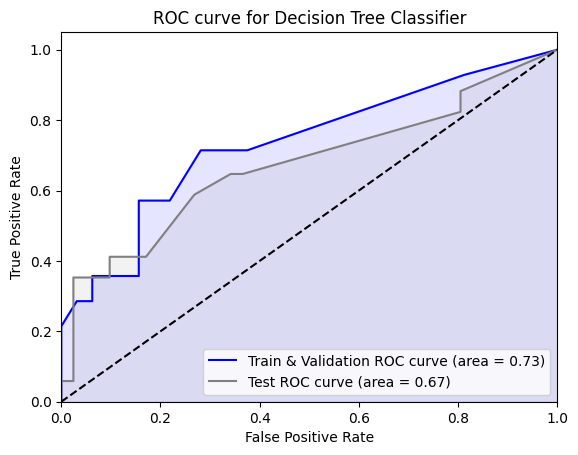

In [37]:
# Calculate ROC curve and AUC for the combined train and validation set
fpr_eval, tpr_eval, _ = roc_curve(y_eval, y_score)
roc_auc_eval = auc(fpr_eval, tpr_eval)

# Calculate ROC curve and AUC for the test set
fpr_test, tpr_test, _ = roc_curve(y_test_encoded, y_test_score)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot the ROC curves
plt.plot(fpr_eval, tpr_eval, label='Train & Validation ROC curve (area = %0.2f)' % roc_auc_eval, color='blue')
plt.fill_between(fpr_eval, tpr_eval, 0, color='blue', alpha=0.1)

plt.plot(fpr_test, tpr_test, label='Test ROC curve (area = %0.2f)' % roc_auc_test, color='grey')
plt.fill_between(fpr_test, tpr_test, 0, color='grey', alpha=0.1)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for Decision Tree Classifier')
plt.legend(loc="lower right")
plt.show()


In [38]:
from sklearn import set_config
from IPython.display import display
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import RandomOverSampler
from sklearn.neighbors import KNeighborsClassifier

# Define the columns for OneHotEncoder (nominal) and OrdinalEncoder (ordinal)
nominal_features = ['node_caps', 'breast_quad', 'irrad']  # list of column indices or names for nominal features
ordinal_features = ['inv_nodes', 'tumour_size']  # list of column indices or names for ordinal features
numerical_features = ['deg_malig']

# Create a ColumnTransformer that applies different encoders to different subsets of features
preprocessor = ColumnTransformer(transformers=[
    ('onehot', OneHotEncoder(), nominal_features),
    ('ordinal', OrdinalEncoder(), ordinal_features),
    ('numerical', 'passthrough', numerical_features)
])

# Enable the diagram display option
set_config(display='diagram')

# Create a pipeline with a preprocessor, a random over sampler, and a K-neighbors classifier
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('ros', RandomOverSampler(random_state=42, sampling_strategy='minority')),
    ('model', KNeighborsClassifier())
])

# Display the pipeline in the Jupyter notebook
display(pipeline)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('onehot', OneHotEncoder(),
                                                  ['node_caps', 'breast_quad',
                                                   'irrad']),
                                                 ('ordinal', OrdinalEncoder(),
                                                  ['inv_nodes', 'tumour_size']),
                                                 ('numerical', 'passthrough',
                                                  ['deg_malig'])])),
                ('ros',
                 RandomOverSampler(random_state=42,
                                   sampling_strategy='minority')),
                ('model', KNeighborsClassifier())])